# WAIT YOU ARE ABOUT TO OVERWRITE YOUR SAVED MODEL!

In [2]:
SEED = 9

import os
os.environ['PYTHONHASHSEED'] = str(SEED)

import random
random.seed(SEED)

import numpy as np
rng = np.random.default_rng(SEED) 
ss = rng.bit_generator._seed_seq # use for multiprocessing
# child_states = ss.spawn(5)

SEED_states_log = []
# nrg.get_state()

# --------------------------------------------------------------------------


import sys
print(sys.version)
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import plotly
from datetime import datetime
from functools import reduce
import multiprocessing
import concurrent.futures


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)




3.9.6 (default, Jun 30 2021, 10:22:16) 
[GCC 11.1.0]


In [3]:
ticker = "BTC"



path = '///'


file = ticker + '.csv'

url = path + file
df = pd.read_csv(url)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ldf = len(df)
hdf = len(df.columns)
print('The number of rows in ' + ticker + ' dataset is', ldf)
print('The number of columns in ' + ticker + ' dataset is', hdf)


earliest = df.iloc[:1]['timestamp']
earliest = pd.to_datetime(earliest).reset_index(drop=True)[0]
earliest = earliest.strftime('%Y-%m-%d')

latest = df.iloc[-1:]['timestamp']
latest = pd.to_datetime(latest).reset_index(drop=True)[0]
latest = latest.strftime('%Y-%m-%d')

print(type(df["timestamp"]))
print(df)

data = df

The number of rows in BTC dataset is 2767
The number of columns in BTC dataset is 5
<class 'pandas.core.series.Series'>
       timestamp      open      high       low     close
0     2013-12-27    763.28    777.51    713.60    735.07
1     2013-12-28    737.98    747.06    705.35    727.83
2     2013-12-29    728.05    748.61    714.44    745.05
3     2013-12-30    741.35    766.60    740.24    756.13
4     2013-12-31    760.32    760.58    738.17    754.01
...          ...       ...       ...       ...       ...
2762  2021-07-20  30839.65  31063.07  29278.00  29790.35
2763  2021-07-21  29790.34  32858.00  29482.61  32144.51
2764  2021-07-22  32144.51  32591.35  31708.00  32287.83
2765  2021-07-23  32287.58  33650.00  31924.32  33634.09
2766  2021-07-24  33634.10  33777.00  33401.14  33549.99

[2767 rows x 5 columns]


<IPython.core.display.Javascript object>


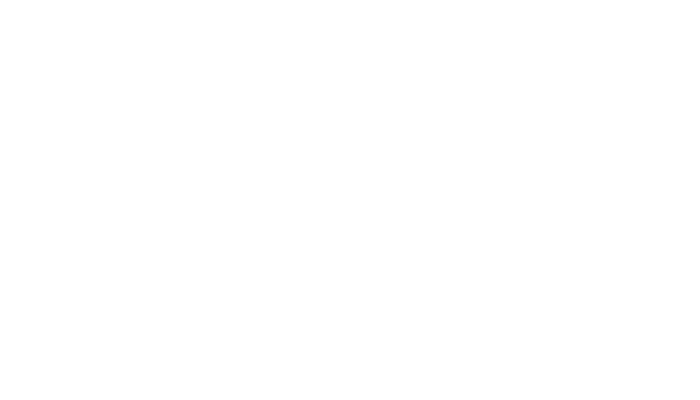

In [5]:
plt.figure(figsize = (7, 4))
bins = np.linspace(-10, 10, 100)

rng = np.random.default_rng(SEED) 

solution = rng.standard_normal(100)
w = rng.standard_normal(100)

plt.hist(solution, bins, alpha = 0.5, label = 'solution', color = 'r')
plt.hist(w, bins, alpha = 0.5, label = 'random', color = 'y')
plt.legend()
plt.show()

In [6]:
def f(w):
    return -np.sum(np.square(solution - w))


npop = 50
sigma = 0.1
alpha = 0.001

for i in range(5000):
    rng = np.random.default_rng(SEED) 
    if (i + 1) % 1000 == 0:
        print(
            'iter %d. w: %s, solution: %s, reward: %f'
            % (i + 1, str(w[-1]), str(solution[-1]), f(w))
        )
    N = rng.standard_normal((npop, 100))
    R = np.zeros(npop)
    for j in range(npop):
        w_try = w + sigma * N[j]
        R[j] = f(w_try)

    A = (R - np.mean(R)) / np.std(R)
    w = w + alpha / (npop * sigma) * np.dot(N.T, A)

iter 1000. w: 2.226242536893862, solution: 2.229274008198227, reward: -1.522777
iter 2000. w: 2.154911075250325, solution: 2.229274008198227, reward: -0.525489
iter 3000. w: 2.154911075250328, solution: 2.229274008198227, reward: -0.525489
iter 4000. w: 2.154911075250332, solution: 2.229274008198227, reward: -0.525489
iter 5000. w: 2.1549110752503395, solution: 2.229274008198227, reward: -0.525489


<IPython.core.display.Javascript object>


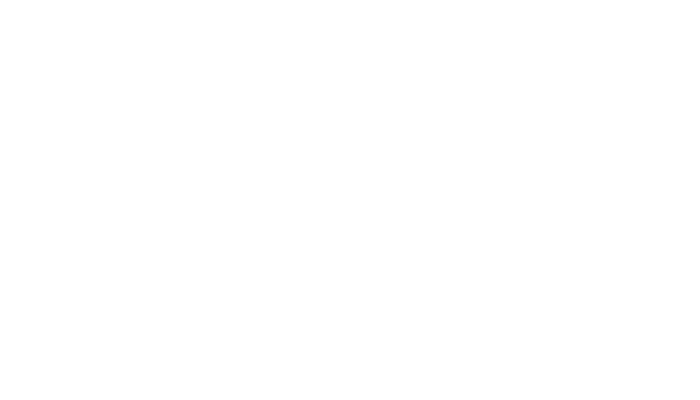

In [7]:
'''
I want to compare my first two individuals with my real w
'''
plt.figure(figsize=(7,4))

rng = np.random.default_rng(SEED) 

sigma = 0.1
N = rng.standard_normal((npop, 100))
individuals = []
for j in range(2):
    individuals.append(w + sigma * N[j])
    
    
plt.hist(w, bins, alpha=0.5, label='w',color='r')
plt.hist(individuals[0], bins, alpha=0.5, label='individual 1')
plt.hist(individuals[1], bins, alpha=0.5, label='individual 2')
plt.legend()
plt.show()

In [8]:
df = data.copy()
name = 'Deep Evolution Strategy'

In [9]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [10]:
close = df.close.values.tolist()
get_state(close, 0, 10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
get_state(close, 1, 10)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -7.24]])

In [12]:
get_state(close, 2, 10)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -7.24, 17.22]])

In [13]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        rng = np.random.default_rng(SEED) 
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(rng.standard_normal((w.shape)))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')

In [14]:
class Model:
    
    def __init__(self, input_size, layer_size, output_size):
        rng = np.random.default_rng(SEED) 
        self.weights = [
            rng.standard_normal((input_size, layer_size)),
            rng.standard_normal((layer_size, output_size)),
            rng.standard_normal((layer_size, 1)),
            rng.standard_normal((1, layer_size)),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [15]:
window_size = 30
model = Model(window_size, 500, 3)

In [16]:
initial_money = 1
starting_money = initial_money
spend_percent = 100 # %
fee = 0.3
len_close = len(close) - 1
weight = model
skip = 1

state = get_state(close, 0, window_size + 1)
inventory = []


buy_action = 0
sell_action = 0

quantity = 0

max_buy = 1
max_sell = 1


def act(model, sequence):
    decision, buy = model.predict(np.array(sequence))
    return np.argmax(decision[0]), int(buy[0])


for t in range(0, len_close, skip):
    action, buy = act(weight, state)
    next_state = get_state(close, t + 1, window_size + 1)

    
    if action == 1 and initial_money >0 and buy_action != 1:
        buy_action = 1
        sell_action = 0
        
        buy_units = (initial_money * (spend_percent/100)) / close[t]
        
        total_buy = buy_units * close[t]
        initial_money -= total_buy  - (total_buy*(fee/100))   # 0.3% fee  
        inventory.append(total_buy)
        quantity += buy_units 
        
        print(
            'day %d: buy %d units at price %f, total balance %f'
            % (t, buy_units, total_buy, initial_money)
        )        
    elif action == 2 and len(inventory) > 0 and sell_action != 2:
        buy_action = 0
        sell_action = 2
        
        bought_price = inventory.pop(0)
        
        sell_units = quantity
        
#         if sell_units < 1:
#             continue  
            
        quantity -= sell_units
        total_sell = sell_units * close[t]
        initial_money += total_sell  - (total_sell*(fee/100))   # 0.3% fee  
        
        try:
            invest = ((total_sell - bought_price) / bought_price) * 100
        except:
            invest = 0
        print(
            'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
            % (t, sell_units, total_sell, invest, initial_money)
        )

    state = next_state
((initial_money - starting_money) / starting_money) * 100

day 0: buy 0 units at price 1.000000, total balance 0.003000
day 2, sell 0 units at price 1.013577, investment 1.357694 %, total balance 1.013536,
day 11: buy 0 units at price 1.013536, total balance 0.003041
day 13, sell 0 units at price 1.070229, investment 5.593516 %, total balance 1.070058,
day 17: buy 0 units at price 1.070058, total balance 0.003210
day 23, sell 0 units at price 1.107915, investment 3.537803 %, total balance 1.107801,
day 24: buy 0 units at price 1.107801, total balance 0.003323
day 25, sell 0 units at price 1.099794, investment -0.722822 %, total balance 1.099818,
day 26: buy 0 units at price 1.099818, total balance 0.003299
day 30, sell 0 units at price 1.151441, investment 4.693764 %, total balance 1.151286,
day 31: buy 0 units at price 1.151286, total balance 0.003454
day 32, sell 0 units at price 1.212657, investment 5.330637 %, total balance 1.212473,
day 33: buy 0 units at price 1.212473, total balance 0.003637
day 37, sell 0 units at price 1.211548, inves

day 1511: buy 0 units at price 1.227055, total balance 0.003681
day 1512, sell 0 units at price 1.235202, investment 0.663952 %, total balance 1.235177,
day 1514: buy 0 units at price 1.235177, total balance 0.003706
day 1515, sell 0 units at price 1.314016, investment 6.382797 %, total balance 1.313780,
day 1516: buy 0 units at price 1.313780, total balance 0.003941
day 1520, sell 0 units at price 1.130529, investment -13.948368 %, total balance 1.131079,
day 1522: buy 0 units at price 1.131079, total balance 0.003393
day 1523, sell 0 units at price 1.170237, investment 3.462047 %, total balance 1.170120,
day 1525: buy 0 units at price 1.170120, total balance 0.003510
day 1526, sell 0 units at price 1.184587, investment 1.236417 %, total balance 1.184544,
day 1531: buy 0 units at price 1.184544, total balance 0.003554
day 1538, sell 0 units at price 0.982980, investment -17.016187 %, total balance 0.983584,
day 1539: buy 0 units at price 0.983584, total balance 0.002951
day 1543, sell

day 2504: buy 0 units at price 0.517002, total balance 0.001551
day 2505, sell 0 units at price 0.569858, investment 10.223480 %, total balance 0.569699,
day 2507: buy 0 units at price 0.569699, total balance 0.001709
day 2509, sell 0 units at price 0.589311, investment 3.442433 %, total balance 0.589252,
day 2513: buy 0 units at price 0.589252, total balance 0.001768
day 2515, sell 0 units at price 0.576121, investment -2.228458 %, total balance 0.576160,
day 2519: buy 0 units at price 0.576160, total balance 0.001728
day 2520, sell 0 units at price 0.603761, investment 4.790533 %, total balance 0.603678,
day 2531: buy 0 units at price 0.603678, total balance 0.001811
day 2533, sell 0 units at price 0.624812, investment 3.500887 %, total balance 0.624749,
day 2534: buy 0 units at price 0.624749, total balance 0.001874
day 2535, sell 0 units at price 0.641402, investment 2.665556 %, total balance 0.641352,
day 2538: buy 0 units at price 0.641352, total balance 0.001924
day 2539, sell 0

5.846724797451763

In [17]:
import time


class Agent:
    
    rng = np.random.default_rng(SEED) 

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, spend_percent, fee, max_buy, max_sell, close, window_size, skip
    ):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.spend_percent = spend_percent
        self.fee = fee
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        spend_percent = self.spend_percent
        fee = self.fee
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        buy_action = 0
        sell_action = 0
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money > 0 and buy_action != 1:
                buy_action = 1
                sell_action = 0

                buy_units = (initial_money * (spend_percent/100)) / close[t]
                    
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy - (total_buy*(fee/100))   # 0.3% fee  
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0 and sell_action != 2:
                buy_action = 0
                sell_action = 2
                
                sell_units = quantity
                
#                 if sell_units < 1:
#                     continue
                    
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell - (total_sell*(fee/100))   # 0.3% fee  

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        spend_percent = self.spend_percent
        fee = self.fee
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        buy_action = 0
        sell_action = 0
        quantity = 0
        total_return = []
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money > 0 and buy_action != 1:
                buy_action = 1
                sell_action = 0
                
                buy_units = (initial_money * (spend_percent/100)) / close[t]
                
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy - (total_buy*(fee/100))   # 0.3% fee  
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
#                 total_return.append([t,initial_money])
            elif action == 2 and len(inventory) > 0 and sell_action != 2:
                buy_action = 0
                sell_action = 2
        
                bought_price = inventory.pop(0)
            
                sell_units = quantity
                
#                 if sell_units < 1:
#                     continue
                    
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell - (total_sell*(fee/100))   # 0.3% fee 
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                total_return.append([t,initial_money])
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        
        
    
        plt.figure(figsize = (7, 4))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.savefig('///'+name+'.png')
        plt.show()
        
        


        sbuy = pd.DataFrame(index=df.index, 
                          data=None, 
                          columns=['buy'])

        ssell = pd.DataFrame(index=df.index, 
                          data=None, 
                          columns=['sell'])

        algo_return = pd.DataFrame(index=df.index, 
                          data=None, 
                          columns=['return'])


        for i in sbuy.index:
            for j in states_buy:
                if j == i:
                    sbuy['buy'].iloc[i:i+1] = "BUT"

        for i in ssell.index:
            for j in states_sell:
                if j == i:
                    ssell['sell'].iloc[i:i+1] = "SELL"
                    
        for i in algo_return.index:
            for j in total_return:
                if j[0] == i:
                    algo_return['return'].iloc[i:i+1] = j[1]              

        algo_return['return'].iloc[:1] = starting_money
        
        algo_return['return'] = algo_return['return'].interpolate(method='linear', axis=0).ffill()

        bsdf = pd.concat([df, sbuy, ssell,algo_return], axis=1)            
        
        path = '///'
        file = ticker + "_deep_evo_signal.csv"
        out = path + file
        bsdf.to_csv(out,index=False)
        



In [18]:
import pickle
import datetime

# load exisiting model

# now = datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
 
# model_file = "///" + ticker + "_model_percent_max"
 
# with open(model_file, 'rb') as f:
#     _trained_model = pickle.load(f)  

# model = _trained_model

model = Model(input_size = window_size, layer_size = 500, output_size = 3)

agent = Agent(
    model = model,
    money = 1,
    spend_percent = 100,  # %
    fee = 0.3,    # 0.3% fee 
    max_buy = 1,
    max_sell = 1,
    close = close,
    window_size = window_size,
    skip = 1,
)

In [19]:
agent.fit(iterations = 369, checkpoint = 10)

iter 10. reward: 266161.894115
iter 20. reward: 311905.449307
iter 30. reward: 233747.289562
iter 40. reward: 249356.020456
iter 50. reward: 290358.650271
iter 60. reward: 259203.558758
iter 70. reward: 217511.091384
iter 80. reward: 262042.447667
iter 90. reward: 419956.801263
iter 100. reward: 325089.770165
iter 110. reward: 283772.416276
iter 120. reward: 275708.580754
iter 130. reward: 232358.819754
iter 140. reward: 242121.034391
iter 150. reward: 282435.262887
iter 160. reward: 360364.078890
iter 170. reward: 354111.693134
iter 180. reward: 429643.448852
iter 190. reward: 294431.368438
iter 200. reward: 281257.177369
iter 210. reward: 250374.502543
iter 220. reward: 266136.944934
iter 230. reward: 312322.756678
iter 240. reward: 282627.163171
iter 250. reward: 315170.885908
iter 260. reward: 303922.021064
iter 270. reward: 282387.275031
iter 280. reward: 264479.786899
iter 290. reward: 402236.513675
iter 300. reward: 411413.072532
iter 310. reward: 563111.364962
iter 320. reward:

day 1: buy 0 units at price 1.000000, total balance 0.003000
day 12, sell 0 units at price 1.157853, investment 15.785280 %, total balance 1.157379,
day 17: buy 0 units at price 1.157379, total balance 0.003472
day 18, sell 0 units at price 1.146469, investment -0.942701 %, total balance 1.146501,
day 22: buy 0 units at price 1.146501, total balance 0.003440
day 23, sell 0 units at price 1.188758, investment 3.685714 %, total balance 1.188631,
day 24: buy 0 units at price 1.188631, total balance 0.003566
day 26, sell 0 units at price 1.155016, investment -2.828085 %, total balance 1.155117,
day 28: buy 0 units at price 1.155117, total balance 0.003465
day 29, sell 0 units at price 1.237055, investment 7.093480 %, total balance 1.236809,
day 31: buy 0 units at price 1.236809, total balance 0.003710
day 32, sell 0 units at price 1.302739, investment 5.330637 %, total balance 1.302541,
day 33: buy 0 units at price 1.302541, total balance 0.003908
day 35, sell 0 units at price 1.308722, in

day 1059: buy 0 units at price 24.000397, total balance 0.072001
day 1071, sell 0 units at price 25.540496, investment 6.416973 %, total balance 25.535875,
day 1072: buy 0 units at price 25.535875, total balance 0.076608
day 1075, sell 0 units at price 25.306067, investment -0.899943 %, total balance 25.306756,
day 1076: buy 0 units at price 25.306756, total balance 0.075920
day 1081, sell 0 units at price 25.700790, investment 1.557028 %, total balance 25.699608,
day 1084: buy 0 units at price 25.699608, total balance 0.077099
day 1107, sell 0 units at price 30.009904, investment 16.771839 %, total balance 29.996974,
day 1111: buy 0 units at price 29.996974, total balance 0.089991
day 1112, sell 0 units at price 31.041021, investment 3.480508 %, total balance 31.037889,
day 1116: buy 0 units at price 31.037889, total balance 0.093114
day 1119, sell 0 units at price 33.558903, investment 8.122377 %, total balance 33.551340,
day 1122: buy 0 units at price 33.551340, total balance 0.1006

day 2259, sell 3 units at price 34811.972355, investment 2.566726 %, total balance 34809.358853,
day 2261: buy 3 units at price 34809.358853, total balance 104.428077
day 2264, sell 3 units at price 30227.476761, investment -13.162788 %, total balance 30241.222407,
day 2267: buy 6 units at price 30241.222407, total balance 90.723667
day 2268, sell 6 units at price 35146.600692, investment 16.220833 %, total balance 35131.884557,
day 2271: buy 6 units at price 35131.884557, total balance 105.395654
day 2274, sell 6 units at price 43049.704301, investment 22.537418 %, total balance 43025.950842,
day 2275: buy 6 units at price 43025.950842, total balance 129.077853
day 2276, sell 6 units at price 42877.780499, investment -0.344374 %, total balance 42878.225010,
day 2277: buy 7 units at price 42878.225010, total balance 128.634675
day 2279, sell 7 units at price 49723.551292, investment 15.964575 %, total balance 49703.015314,
day 2280: buy 7 units at price 49703.015314, total balance 149.

<IPython.core.display.Javascript object>


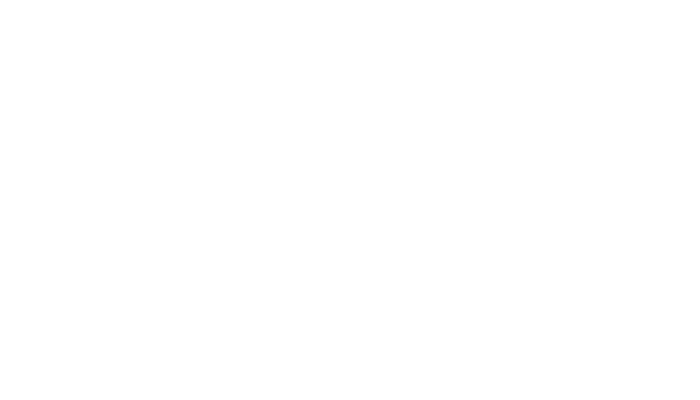

In [20]:
agent.buy()

In [21]:
import pickle
import datetime

model_file = "///" + ticker + "_model_percent_max"


with open(model_file, 'wb') as f:
    pickle.dump(model, f)
    
with open(model_file + "_bak", 'wb') as f:
    pickle.dump(model, f)    
    

In [22]:
def get_df(ticker,return_len=None,loc=1):
    
    if loc == 1:
        path = '///'
        file = ticker + '.csv'
        url = path + file
        df = pd.read_csv(url)
        
    if loc == 2:
        path = '///'
        file = ticker + "_deep_evo_signal.csv"
        url = path + file
        df = pd.read_csv(url)
        

    df = df.rename(columns={"timestamp": "Date"})

    earliest = df.iloc[:1]['Date']
    earliest = pd.to_datetime(earliest).reset_index(drop=True)[0]
    earliest = earliest.strftime('%Y-%m-%d')

    latest = df.iloc[-1:]['Date']
    latest = pd.to_datetime(latest).reset_index(drop=True)[0]
    latest = latest.strftime('%Y-%m-%d')


    df["Date"] = pd.to_datetime(df["Date"])
#     df["Date"] = df["Date"].dt.strftime("%Y%m%d")
    df = df.set_index("Date")

    if return_len == True:
        return df.tail(return_len)
    else:
        return df



In [23]:
baseline_returns = get_df(ticker,return_len=ldf)
baseline_returns["% Returns"] = baseline_returns["close"].pct_change()
baseline_returns = pd.Series(baseline_returns["% Returns"].values, index=baseline_returns.index, name = "Benchmark")


print(type(baseline_returns),baseline_returns)


test_returns = get_df(ticker,return_len=ldf,loc=2)
test_returns["% Returns"] = test_returns["return"].pct_change()
test_returns = pd.Series(test_returns["% Returns"].values, index=test_returns.index)


print(type(test_returns),test_returns)


<class 'pandas.core.series.Series'> Date
2013-12-27         NaN
2013-12-28   -0.009849
2013-12-29    0.023659
2013-12-30    0.014871
2013-12-31   -0.002804
                ...   
2021-07-20   -0.034024
2021-07-21    0.079024
2021-07-22    0.004459
2021-07-23    0.041696
2021-07-24   -0.002500
Name: Benchmark, Length: 2767, dtype: float64
<class 'pandas.core.series.Series'> Date
2013-12-27         NaN
2013-12-28    0.000000
2013-12-29    0.000000
2013-12-30    0.000000
2013-12-31    0.000000
                ...   
2021-07-20   -0.062377
2021-07-21    0.000000
2021-07-22    0.000000
2021-07-23    0.000000
2021-07-24    0.000000
Length: 2767, dtype: float64


Start date,2013-12-27
End date,2021-07-24
Total months,131
,Backtest
Annual return,258.877%
Cumulative returns,123990759.309%
Annual volatility,73.832%
Sharpe ratio,2.01
Calmar ratio,9.65
Stability,0.98
Max drawdown,-26.83%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.83,2014-10-16,2015-01-11,2015-01-26,73
1,20.53,2020-02-15,2020-03-09,2020-03-19,24
2,18.55,2018-09-05,2018-12-15,2018-12-20,77
3,17.12,2018-03-07,2018-04-05,2018-04-23,34
4,14.54,2018-01-21,2018-01-30,2018-02-09,15


Stress Events,mean,min,max
Apr14,0.07%,-7.35%,10.77%
Oct14,0.35%,-6.46%,7.74%
Fall2015,0.22%,-2.60%,7.37%
New Normal,0.59%,-13.12%,132.01%


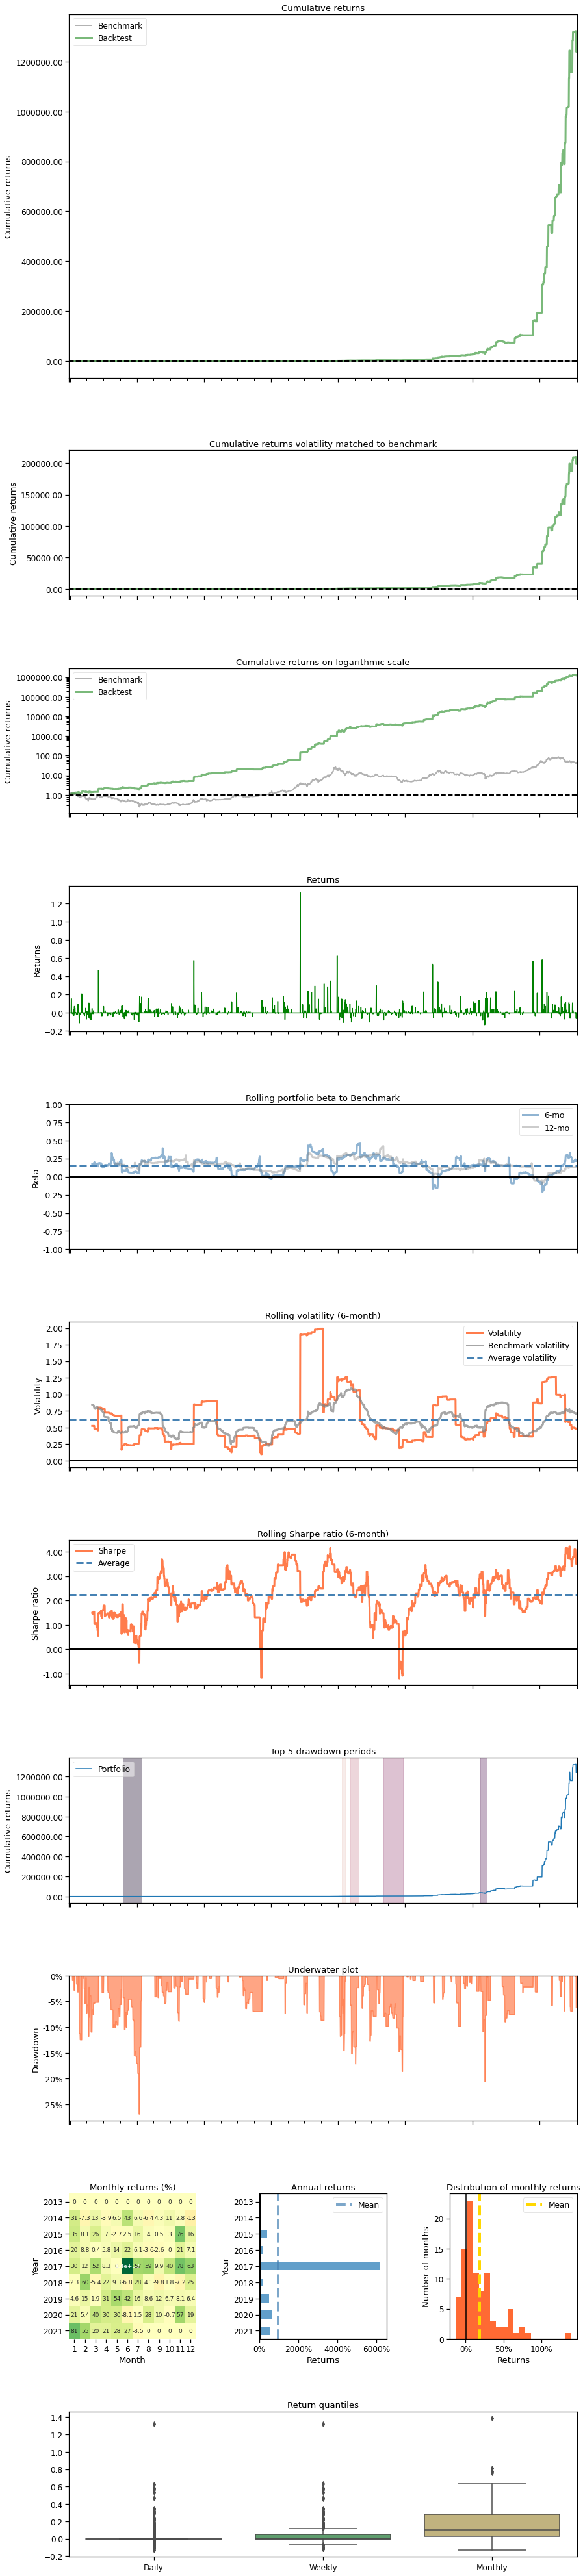

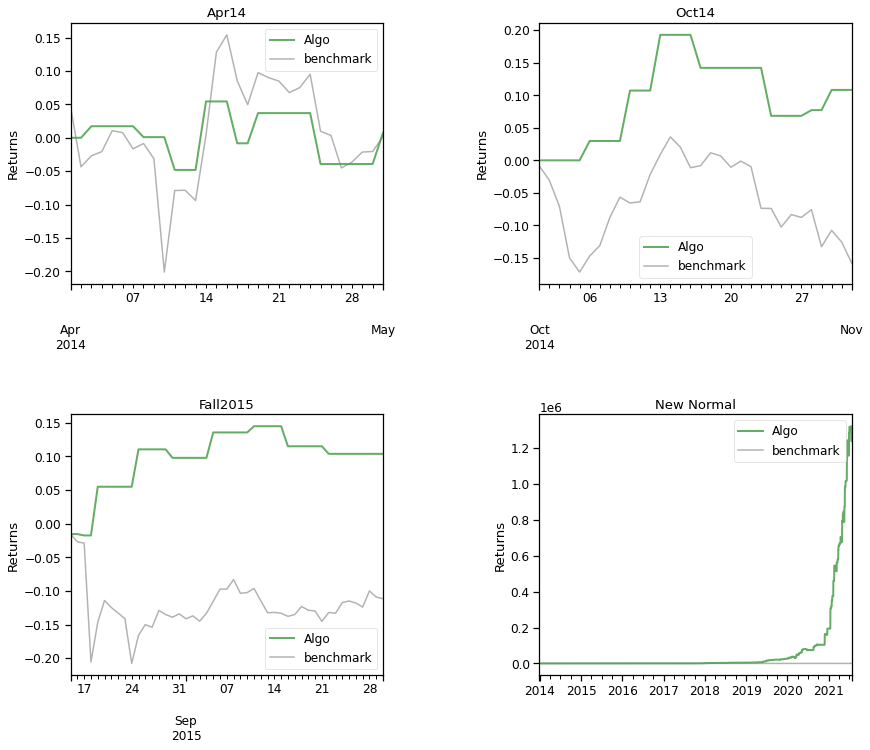

In [24]:
import pyfolio as pf
from copy import deepcopy
%matplotlib inline

# pf.create_full_tear_sheet(baseline_returns)

with pf.plotting.plotting_context(font_scale=1.1):
    pf.create_full_tear_sheet(
        returns=test_returns, benchmark_rets=baseline_returns, set_context=False
    )
